# Quantum Optimal Control with Reinforcement Learning

In this notebook, we will demonstrate how to use the `_RL` module to solve a quantum optimal control problem using reinforcement learning (RL).
The goal is to use 2 Qubits to realize CNOT gate. In practice there is a control qubit and a target qubit, if the control qubit is in the state |0⟩ the target qubit remains unchanged, if the control qubit is in the state |1⟩ the CNOT gate flips the state of the target qubit.


### Setup and Import Required Libraries

In [1]:
# If you are running this in an environment where some packages are missing, use this cell to install them:
# !pip install qutip stable-baselines3 gymnasium

import qutip as qt
import numpy as np
from stable_baselines3 import PPO
from qutip_qoc import Objective
#from _rl import _RL
import matplotlib.pyplot as plt

In [2]:
#this is just for using local files (not yet merged in github)
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'Github', 'qutip-qoc', 'src', 'qutip_qoc'))

sys.path.append(module_path)

from _rl import _RL
from pulse_optim import optimize_pulses

### Define the Quantum Control Problem

The system starts from an initial state represented by the identity on two qubits, with the goal of achieving a CNOT gate as the target state. To accomplish this, control operators based on the Pauli matrices are defined to act on individual qubits and pairs of qubits. Additionally, a drift Hamiltonian is introduced to account for interactions between the qubits and noise, thereby modeling the dynamics of the open quantum system.

In [4]:
# Define the initial and target states
initial = qt.tensor(qt.qeye(2), qt.qeye(2))
target  = qt.gates.cnot()

# convert to superoperator (for open system)
initial = qt.sprepost(initial, initial.dag())
target  = qt.sprepost(target,  target.dag())

# single qubit control operators
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
identity = qt.qeye(2)

# two qubit control operators
i_sx, sx_i = qt.tensor(sx, identity), qt.tensor(identity, sx)
i_sy, sy_i = qt.tensor(sy, identity), qt.tensor(identity, sy)
i_sz, sz_i = qt.tensor(sz, identity), qt.tensor(identity, sz)

# Define the control Hamiltonians
Hc = [i_sx, i_sy, i_sz, sx_i, sy_i, sz_i]
Hc = [qt.liouvillian(H) for H in Hc]

# drift and noise term for a two-qubit system
omega, delta, gamma = 0.1, 1.0, 0.1
i_sm, sm_i = qt.tensor(qt.sigmam(), identity), qt.tensor(identity, qt.sigmam())

# energy levels and interaction
Hd = omega * (i_sz + sz_i) + delta * i_sz * sz_i
Hd = qt.liouvillian(H=Hd, c_ops=[gamma * (i_sm + sm_i)])

# combined operator list
H = [Hd, Hc[0], Hc[1], Hc[2], Hc[3], Hc[4], Hc[5]]

# Define the objective
objectives = [Objective(initial, H, target)]

# Define the control parameters with bounds
control_parameters = {
    "p": {"bounds": [(-30, 30)]}
}

# Define the time interval
tlist = np.linspace(0, np.pi, 100)

# Define algorithm-specific settings
algorithm_kwargs = {
    "fid_err_targ": 0.01,
    "alg": "RL",
    "max_iter": 400,
    "shorter_pulses": False,
}
optimizer_kwargs = {}


Note that `max_iter` defines the number of episodes, the 100 in `tlist` defines the maximum number of steps per episode

### Initialize and Train the RL Environment

Now we will call the `optimize_pulses()` method, passing it the control problem we defined.
The method will create an instance of the `_RL` class, which will set up the reinforcement learning environment and start training.
Finally it returns the optimization results through an object of the `Result` class.

In [5]:
# Initialize the RL environment and start training
rl_result = optimize_pulses(
    objectives,
    control_parameters,
    tlist,
    algorithm_kwargs,
    optimizer_kwargs
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -88.6    |
| time/              |          |
|    fps             | 573      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -88.6       |
| time/                   |             |
|    fps                  | 520         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009919285 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss   

### Analyze the Results

After the training is complete, we can analyze the results obtained by the RL agent. 
In the above window showing the output produced by Gymansium, you can observe how during training the number of steps per episode (ep_len_mean) decreases and the average reward of the episodes (ep_rew_mean) increases.

We can now see the fields of the `Result` class, this includes the final infidelity, the optimized control parameters and more.

In [6]:
print(rl_result)

Control Optimization Result
--------------------------
- Started at 2024-08-26 18:54:31
- Number of objectives: 1
- Final fidelity error: 0.9678450426696734
- Final parameters: [[-3.1087526679039, -8.416411578655243, 30.0, 17.213022708892822, 14.167898297309875, 30.0], [30.0, -18.649579882621765, 30.0, 4.698044657707214, 8.504285216331482, -13.694652915000916], [30.0, 30.0, -30.0, -30.0, 0.3120405972003937, -30.0], [30.0, -9.982881546020508, -7.644322514533997, -30.0, -21.7467999458313, 22.356192469596863], [-16.941781640052795, 23.70549201965332, -5.7092490792274475, -3.1341876089572906, -30.0, -22.90980041027069], [2.145122140645981, -29.785653948783875, 30.0, 24.86776828765869, -30.0, 30.0], [18.50911259651184, 20.09882926940918, -21.215654611587524, 2.6178836077451706, -10.580383837223053, -30.0], [30.0, 28.613587617874146, 30.0, 1.297985091805458, -11.024004220962524, 17.568976879119873], [-12.576630413532257, 4.3459005653858185, -10.798923969268799, -3.521493226289749, 24.4442349

Text(0.5, 1.0, 'hinton')

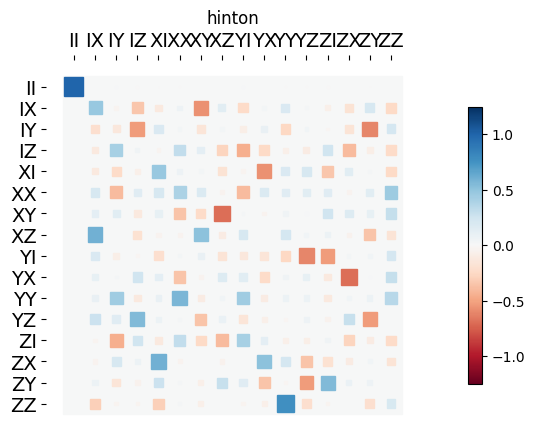

In [8]:
# We can show the hinton matrix
fig, ax = qt.hinton(rl_result._final_states[0])
ax.set_title('hinton')